In [1]:
import mteb, pickle, os, sys, json, glob, umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

from adjustText import adjust_text  # label adjustment
from mteb import MTEB
from collections import defaultdict
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from llama_index.core.schema import NodeRelationship


# MTEB embedding model evaluation

In [3]:
model_names = { "BAAI/bge-small-en-v1.5",
                "all-mpnet-base-v2",
                "BAAI/bge-m3",
                "all-MiniLM-L6-v2",  
                "all-MiniLM-L12-v2"}
                
tasks = mteb.get_tasks(tasks=["MedicalQARetrieval", "NFCorpus", "CUREv1", "MedrxivClusteringP2P.v2", "MedrxivClusteringS2S.v2"], languages=["eng"], domains=["Medical"]) # 
evaluation = MTEB(tasks)

In [ ]:
for name in model_names:
    model = SentenceTransformer(name)
    evaluation = MTEB(tasks) 
    if "BAAI/" in name:
        name = name.replace("BAAI/", "")
    results = evaluation.run(model, output_folder=f"results/{name}")


In [ ]:
# Retrieve task names and initialize results_dict directly
task_info = tasks.to_dataframe()[['name', 'type']].rename(columns={'name': 'task'})
task_info = task_info.set_index('task')  # Set 'task' as the index for easier manipulation
task_info = task_info.assign(**{model.split('/')[-1]: None for model in model_names})  # Add model columns with None values

# Process JSON files and populate task_info
for file in glob.glob("/home/lasa14/scratch-llm/results/MTEB/**/*.json", recursive=True):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            task_name = data.get("task_name")
            model_name = next((model.split('/')[-1] for model in model_names if model.split('/')[-1] in file), None)
            main_score = data.get("scores", {}).get("test", [{}])[0].get("main_score") or \
                         data.get("scores", {}).get("all", [{}])[0].get("main_score")

            if task_name in task_info.index and model_name in task_info.columns:
                task_info.at[task_name, model_name] = main_score
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file}")

# Reset index and reorder columns to move 'type' to the second position
results_df = task_info.reset_index()
results_df = results_df[['task', 'type'] + [col for col in results_df.columns if col not in ['task', 'type']]]

# Display the results DataFrame
results_df

,task,type,bge-m3,all-MiniLM-L6-v2,all-MiniLM-L12-v2,bge-small-en-v1.5,all-mpnet-base-v2
0,MedicalQARetrieval,Retrieval,0.68098,0.60299,0.62038,0.65558,0.66517
1,NFCorpus,Retrieval,0.31411,0.31594,0.3225,0.33708,0.33289
2,CUREv1,Retrieval,0.54524,0.3377,0.34691,0.45933,0.34946
3,MedrxivClusteringP2P.v2,Clustering,0.339501,0.3749,0.378205,0.36186,0.398618
4,MedrxivClusteringS2S.v2,Clustering,0.30463,0.357328,0.359373,0.351683,0.369813


# Generate subgraph

## Find nodes that have edges of multiple types:

In [ ]:
with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/all_nodes.pkl'), 'rb') as f:
    all_nodes_embedded = pickle.load(f)

In [ ]:
# Create a dictionary to map node IDs to nodes for faster lookup
node_dict = {node.node_id: node for node in all_nodes_embedded}

# Create a dictionary to track connections between node types
node_type_connections = defaultdict(set)

# Iterate through all nodes and their relationships with a progress bar
for node in tqdm(all_nodes_embedded, desc="Processing nodes"):
    for rel in node.relationships.get(NodeRelationship.CHILD, []):
        target_node = node_dict.get(rel.node_id)  # Use dictionary lookup instead of searching the list
        if target_node:
            target_node_type = target_node.metadata.get('node_type', 'unknown')
            node_type_connections[node.node_id].add(target_node_type)

# Find all nodes connected to at least 4 different types
def find_nodes_with_four_types(node_type_connections):
    nodes_with_four_types = []
    for node_id, connected_types in node_type_connections.items():
        if len(connected_types) >= 10:
            nodes_with_four_types.append((node_id, connected_types))
    return nodes_with_four_types

nodes_with_four_types = find_nodes_with_four_types(node_type_connections)

# Store the nodes with at least 4 different types
if nodes_with_four_types:
    print(f"Found {len(nodes_with_four_types)} nodes with connections to at least 4 different types.")
    for node_id, connected_types in nodes_with_four_types:
        print(f"Node ID: {node_id}, Connected Types: {connected_types}")
else:
    print("No nodes found with connections to at least 4 different types.")

In [167]:
node_index = next((i for i, node in enumerate(all_nodes_embedded) if node.node_id == "12120"), None)
print(f"Node index: {node_index}")
all_nodes_embedded[node_index].metadata

Node index: 98971


{'node_index': '12120',
 'node_id': '5444',
 'node_type': 'gene/protein',
 'node_name': 'PON1',
 'node_source': 'NCBI'}

## Obtain the nodes from the subgraph

In [2]:
#small subgraph with text nodes
def generate_subgraph(all_nodes_embedded):
    """
    Generate a subgraph from the given node embeddings.
    """
    subgraph_nodes = []
    start_node = all_nodes_embedded[98971]
    related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

    related_nodes = []
    edges = []
    for relation in related_nodes_info:
        # Find the related node by its node_id
        related_node = next((node for node in all_nodes_embedded if node.node_id == relation.node_id), None)
        if related_node:
            related_nodes.append(related_node)
            edges.append((start_node.node_id, related_node.node_id, relation.metadata))
    subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors
    return subgraph_nodes


### Plot subgraph with node type labels

Loading file: all_nodes_all-mpnet-base-v2.pkl


/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Loading file: all_nodes_bge-m3.pkl


/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


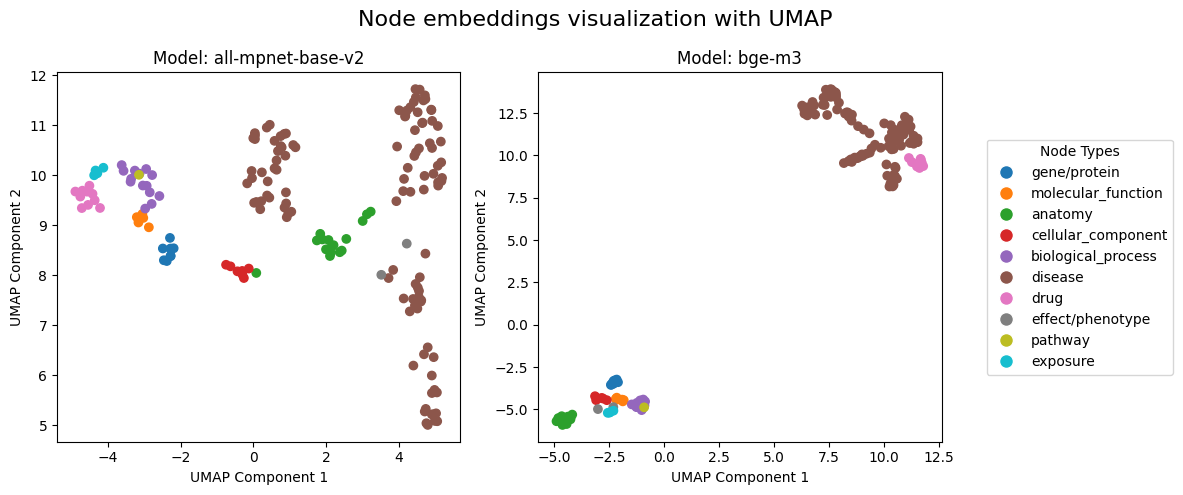

In [8]:
def plot_subgraph_with_legend(subgraph_nodes, embedding_files):
    """
    Plot two subgraphs side by side with a single legend to the right.
    """
    # Create a figure with a GridSpec layout
    fig = plt.figure(figsize=(12, 5))  # Adjust figure size for better readability
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.3])  # Two plots and one space for the legend

    # Dictionary to collect labels and colors for the single legend
    label_to_num_global = {}

    # Iterate over embedding files and create two subplots
    for i, embedding_file in enumerate(embedding_files[:2]):
        print(f"Loading file: {embedding_file}")
        # Load the embeddings for the current model
        with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/{embedding_file}'), 'rb') as f:
            all_nodes_embedded = pickle.load(f)

        # Generate the subgraph
        subgraph_nodes = generate_subgraph(all_nodes_embedded)
        
        # Extract embeddings and labels
        embeddings = np.array([node.embedding for node in subgraph_nodes])
        labels = [node.metadata['node_type'] for node in subgraph_nodes]

        # Perform UMAP dimensionality reduction
        reducer = umap.UMAP(n_components=2, random_state=40)
        reduced_embeddings = reducer.fit_transform(embeddings)

        # Convert labels to numerical values for coloring
        for label in labels:
            if label not in label_to_num_global:
                label_to_num_global[label] = len(label_to_num_global)
        numeric_labels = [label_to_num_global[label] for label in labels]

        # Create a subplot for the current embedding file
        ax = fig.add_subplot(gs[i])
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='tab10')

        if ".pkl" in embedding_file:
            embedding_file = embedding_file.replace(".pkl", "")
            embedding_file = embedding_file.replace("all_nodes_", "")
        ax.set_title(f"Model: {embedding_file.split('/')[-1]}")

    # Create a single legend in the third column
    legend_labels = list(label_to_num_global.keys())
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(label_to_num_global[label]), markersize=10) for label in legend_labels]
    legend_ax = fig.add_subplot(gs[2])
    legend_ax.axis('off')  # Turn off the axis for the legend space
    legend_ax.legend(handles, legend_labels, title="Node Types", loc="center")
    # include a label for the y axis and x axis
    for ax in fig.axes[:-1]:  # Exclude the legend axis
        ax.set_xlabel("UMAP Component 1")
        ax.set_ylabel("UMAP Component 2")

    plt.suptitle("Node embeddings visualization with UMAP", fontsize=16)
    plt.tight_layout()
    plt.show()

embedding_files = [
    "all_nodes_all-mpnet-base-v2.pkl",
    "all_nodes_bge-m3.pkl",
]

# Call the function to plot the subgraph
plot_subgraph_with_legend(subgraph_nodes=None, embedding_files=embedding_files)

# Evaluate clusters

In [3]:
with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/all_nodes_bge-m3.pkl'), 'rb') as f:
    bge_embeddings = pickle.load(f)

with open(os.path.expanduser(f'~/scratch-llm/storage/nodes/all_nodes_all-mpnet-base-v2.pkl'), 'rb') as f:
    mpnet_embeddings = pickle.load(f)

## semantic coherence 

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_disease_clusters(results, all_nodes_embedded, model_name=""):
    """
    Plot disease node embeddings colored by cluster assignments with centroids.
    """
    # Get disease labels in the same order
    subgraph_nodes = generate_subgraph(all_nodes_embedded)
    disease_labels = []
    for node in subgraph_nodes:
        if node.metadata['node_type'] == 'disease':
            disease_labels.append(node.metadata['node_name'])
    
    # Create a mapping from disease names to cluster labels
    label_to_cluster = {}
    for cluster_id, diseases in results['cluster_assignments'].items():
        for disease in diseases:
            label_to_cluster[disease] = cluster_id

    # Map labels to cluster IDs
    numeric_labels = [label_to_cluster[label] for label in disease_labels]

    # Plot the embeddings
    plt.figure(figsize=(15, 12))  # Larger figure size
    colors1 = plt.cm.get_cmap('tab20', results['optimal_k'])
    colors2 = plt.cm.get_cmap('tab20b', results['optimal_k'])
    colors3 = plt.cm.get_cmap('tab20c', results['optimal_k'])
    all_colors = np.concatenate([colors1.colors, colors2.colors, colors3.colors])
    combined_cmap = mcolors.ListedColormap(np.unique(all_colors, axis=0))

    # Get unique cluster labels from your data and create a mapping
    unique_labels = sorted(np.unique(numeric_labels))
    random_indices = np.random.permutation(len(unique_labels))
    label_to_color_map = {label: random_indices[i] for i, label in enumerate(unique_labels)}
    mapped_labels = [label_to_color_map[label] for label in numeric_labels]

    plot_data = []
    for i, label in enumerate(disease_labels):
        plot_data.append({
            'x': results['reduced_embeddings'][i, 0],
            'y': results['reduced_embeddings'][i, 1],
            'cluster': numeric_labels[i],
            'text': label,
            'color_idx': mapped_labels[i]
        })

    # Now you can plot easily:
    plt.figure(figsize=(15, 12))
    texts = []
    for entry in plot_data:
        plt.scatter(entry['x'], entry['y'], color=combined_cmap.colors[entry['color_idx']], s=100)
        # Optionally add text
        txt_obj = plt.text(entry['x'], entry['y'], entry['text'], fontsize=9, ha='center', va='center')
        texts.append(txt_obj)

    adjust_text(texts,
        arrowprops=dict(arrowstyle="->", color='gray', lw=0.5, alpha=0.7),
        expand_points=(2, 2),
        expand_text=(1.5, 1.5),
        force_points=0.5,
        force_text=0.5
    )

    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                markerfacecolor=combined_cmap.colors[label_to_color_map[label]],
                markersize=12)
        for label in unique_labels
    ]

    # Place the legend
    plt.legend(handles, [int(label)+1 for label in unique_labels], loc='upper left', bbox_to_anchor=(1.02, 0.8),
            title="Clusters", title_fontsize=16, ncol=2)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.title(f"k-means clustering UMAP visualization of the embedding of disease nodes - Model {model_name}")
    plt.show()

In [85]:
def analyze_cluster_semantics_original_space(all_nodes_embedded, random_state):
    """
    Perform clustering in original high-dimensional space, use UMAP only for visualization.
    """
    # Get disease data
    subgraph_nodes = generate_subgraph(all_nodes_embedded)
    disease_embeddings = []
    disease_labels = []
    
    for node in subgraph_nodes:
        if node.metadata['node_type'] == 'disease':
            disease_embeddings.append(node.embedding)
            disease_labels.append(node.metadata['node_name'])
       
    # Cluster in ORIGINAL high-dimensional space
    cluster_range = range(2,  len(disease_embeddings))
    silhouette_scores = []

    for k in cluster_range:
        x_normalized = normalize(disease_embeddings, norm='l2')
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(x_normalized)  # normalized embeddings, to do k-means using cosine similarity instead of euclidean
        silhouette_avg = silhouette_score(x_normalized, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    
    optimal_k = cluster_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k} with silhouette score: {max(silhouette_scores)}")
    
    # Final clustering in original space
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(disease_embeddings)
    
    # UMAP only for visualization
    reducer = umap.UMAP(n_components=2, random_state=random_state, n_jobs=1)
    reduced_embeddings = reducer.fit_transform(disease_embeddings)
    
    # Calculate similarities in original space
    similarity_matrix = cosine_similarity(disease_embeddings)
    
    # Intra-cluster similarities
    intra_cluster_similarities = []
    for i in range(len(disease_embeddings)):
        for j in range(i+1, len(disease_embeddings)):
            if cluster_labels[i] == cluster_labels[j]:
                similarity = similarity_matrix[i, j]
                intra_cluster_similarities.append(similarity)
    
    # Inter-cluster similarities (centroids in original space)
    cluster_centroids_original = []
    for cluster_id in range(optimal_k):
        cluster_embeddings = [disease_embeddings[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
        if cluster_embeddings:
            centroid = np.mean(cluster_embeddings, axis=0)
            cluster_centroids_original.append(centroid)
    
   
    # Inter-cluster similarities
    inter_cluster_similarities = []
    if len(cluster_centroids_original) > 1:
        centroid_similarity_matrix = cosine_similarity(cluster_centroids_original)
        for i in range(len(cluster_centroids_original)):
            for j in range(i+1, len(cluster_centroids_original)):
                inter_cluster_similarities.append(centroid_similarity_matrix[i, j])
    
    avg_intra_sim = np.mean(intra_cluster_similarities) if intra_cluster_similarities else 0.0
    avg_inter_sim = np.mean(inter_cluster_similarities) if inter_cluster_similarities else 0.0
    separation_ratio = avg_intra_sim / avg_inter_sim if avg_inter_sim > 0 else float('inf')
       
    return {
        'optimal_k': optimal_k,
        'silhouette_scores': silhouette_scores,
        'intra_cluster_sim': avg_intra_sim,
        'inter_cluster_sim': avg_inter_sim,
        'separation_ratio': separation_ratio,
        'cluster_assignments': {i: [disease_labels[j] for j, label in enumerate(cluster_labels) if label == i] 
                               for i in range(optimal_k)},
        'cluster_centroids_original': cluster_centroids_original,
        'reduced_embeddings': reduced_embeddings, #only for the UMAP visualization
        'cluster_labels': cluster_labels
    }

Optimal number of clusters: 31 with silhouette score: 0.23593842880712293


/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_3583811/1336679749.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', results['optimal_k'])
/tmp/ipykernel_3583811/1336679749.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors2 = plt.cm.get_cmap('tab20b', results['optimal_k'])
/tmp/ipykernel_3583811/1336679749.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be 

<Figure size 1500x1200 with 0 Axes>

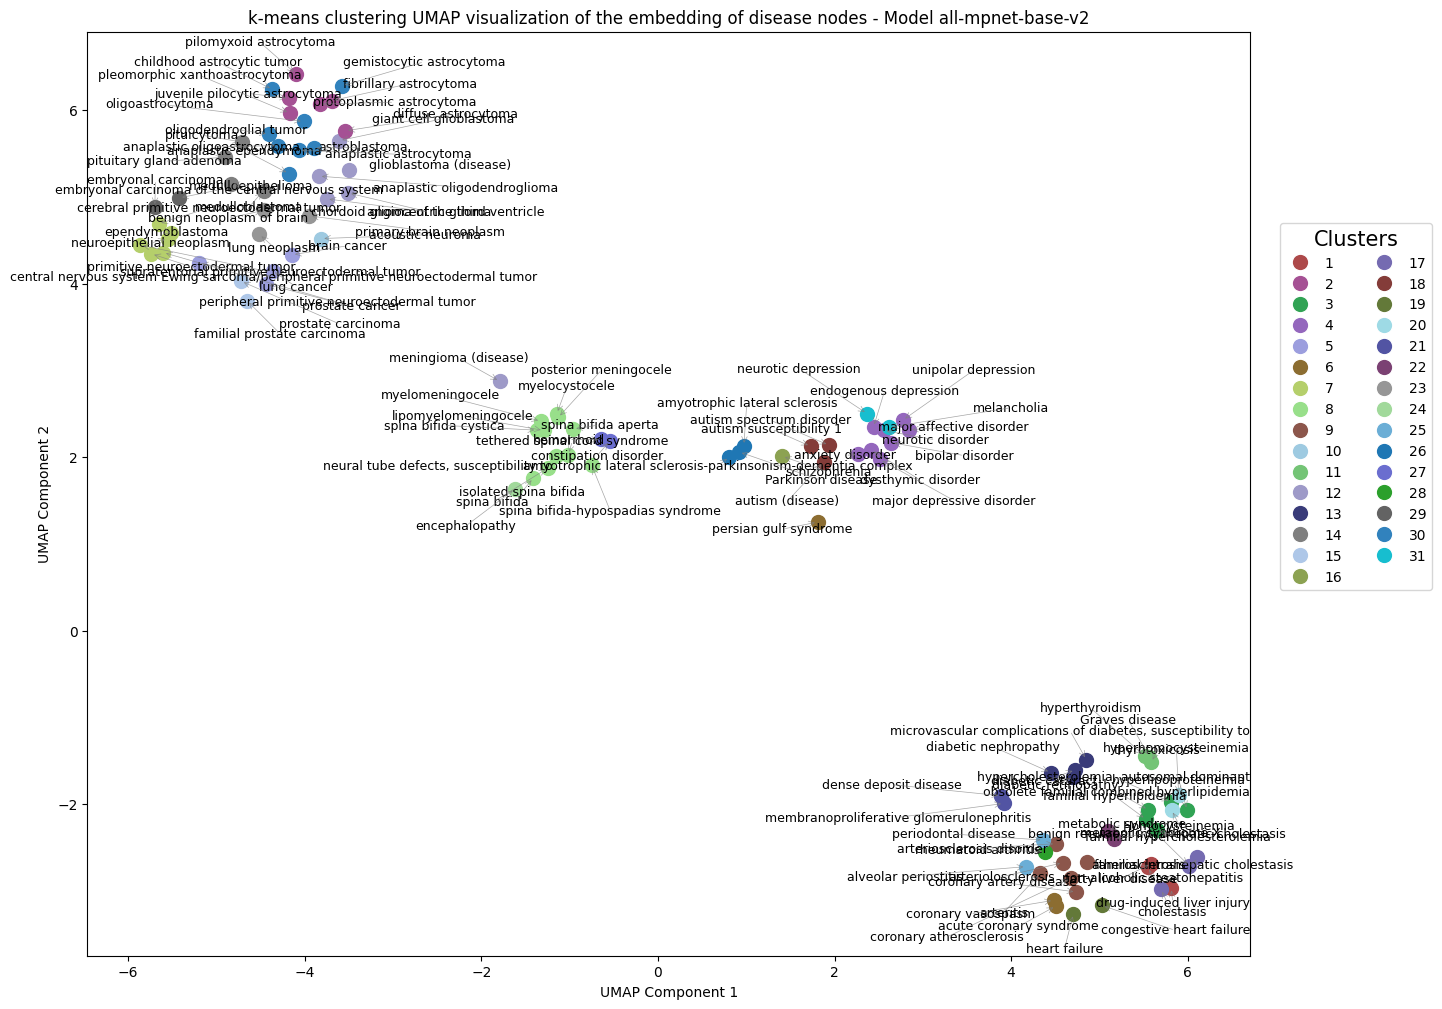

In [241]:
results_mpnet = analyze_cluster_semantics_original_space(all_nodes_embedded=mpnet_embeddings, random_state=40)
plot_disease_clusters(results=results_mpnet, all_nodes_embedded=mpnet_embeddings, model_name="all-mpnet-base-v2")

Optimal number of clusters: 43 with silhouette score: 0.16112172115943896


/home/lasa14/.conda/envs/llm-rag/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_3583811/1336679749.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', results['optimal_k'])
/tmp/ipykernel_3583811/1336679749.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors2 = plt.cm.get_cmap('tab20b', results['optimal_k'])
/tmp/ipykernel_3583811/1336679749.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be 

<Figure size 1500x1200 with 0 Axes>

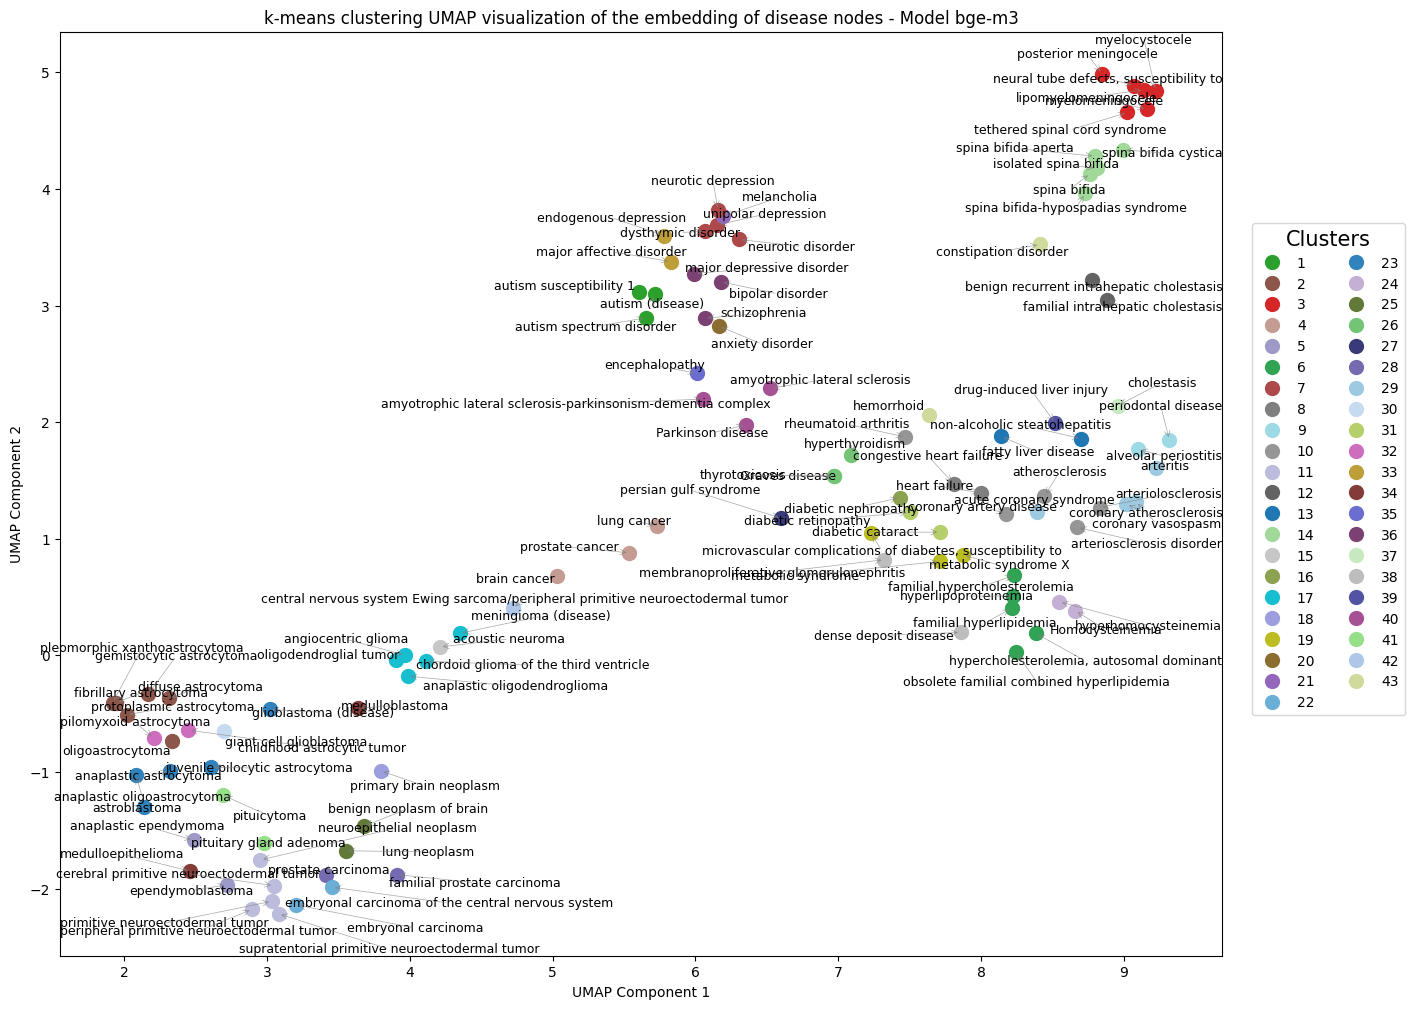

In [245]:
results_bge = analyze_cluster_semantics_original_space(all_nodes_embedded=bge_embeddings, random_state=44)
plot_disease_clusters(results=results_bge, all_nodes_embedded=bge_embeddings, model_name="bge-m3")

In [170]:
# average number of nodes per cluster
print(f"Avg number of diseases per cluster (mpnet): {len(results_mpnet['cluster_assignments'])} clusters, {round(len(results_mpnet['cluster_labels'])/len(results_mpnet['cluster_assignments']), 0)} diseases/cluster")
print(f"Avg number of diseases per cluster (bge): {len(results_bge['cluster_assignments'])} clusters, {round(len(results_bge['cluster_labels'])/len(results_bge['cluster_assignments']), 0)} diseases/cluster")

Avg number of diseases per cluster (mpnet): 31 clusters, 4.0 diseases/cluster
Avg number of diseases per cluster (bge): 43 clusters, 3.0 diseases/cluster


### result tables

In [177]:
# make a table with the results for bge and mpnet
def create_clustering_results_table(results_mpnet, results_bge):
    """
    Create a DataFrame summarizing clustering results for both models.
    """
    data = {
        'Model': ['all-mpnet-base-v2', 'bge-m3'],
        'Optimal k': [results_mpnet['optimal_k'], results_bge['optimal_k']],
        'Silhouette Scores': [round(np.max(results_mpnet['silhouette_scores']),2), round(np.max(results_bge['silhouette_scores']),2)],
        'Intra-cluster Sim': [round(results_mpnet['intra_cluster_sim'],2), round(results_bge['intra_cluster_sim'],2)],
        'Inter-cluster Sim': [round(results_mpnet['inter_cluster_sim'],2), round(results_bge['inter_cluster_sim'],2)],
        'Separation Ratio': [round(results_mpnet['separation_ratio'],2), round(results_bge['separation_ratio'],2)]
    }
    
    df = pd.DataFrame(data)
    return df
results_table = create_clustering_results_table(results_mpnet, results_bge)
results_table


,Model,Optimal k,Silhouette Scores,Intra-cluster Sim,Inter-cluster Sim,Separation Ratio
0,all-mpnet-base-v2,31,0.24,0.72,0.29,2.48
1,bge-m3,43,0.16,0.81,0.60,1.35


In [156]:
# make a table with the diseases that are in the clusters for both models
def create_cluster_diseases_table(results_mpnet, results_bge):
    """
    Create a DataFrame summarizing diseases in clusters for both models.
    """
    data = {
        'Model': [],
        'Cluster number': [],
        'Number of Diseases': [],
        'Diseases': []

    }
    
    for model_name, results in zip(['all-mpnet-base-v2', 'bge-m3'], [results_mpnet, results_bge]):
        for cluster_id, diseases in results['cluster_assignments'].items():
            data['Model'].append(model_name)
            data['Cluster number'].append(cluster_id+1)
            data['Diseases'].append(', '.join([d.capitalize() for d in diseases]))
            data['Number of Diseases'].append(len(diseases))
    
    df = pd.DataFrame(data)
    return df
cluster_diseases_table = create_cluster_diseases_table(results_mpnet, results_bge)
cluster_diseases_table.to_latex("disease_clusters_table.tex", index=False)

